## Background

In this notebook, some of the functions from imblearn library will be used in a severely imbalanced dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud.

The objective of this notebook is to familiar with the state of the art techniques that dealing with imbalanced dataset.

Hence, for the sake of simplicity, the training will be performed by decision tree and there is no cross validation.

<span style="color:blue">In this notebook, only the sampling techniques implemented in imblearn library are used. The sampling techniques are:</span>

<b>1. Random oversampling and undersampling </b><br>
<t>1.1. Random oversampling </t><br>
<t>1.2. Random undersampling </t><br>

<b>2. Informed undersampling </b><br>
<t>2.1. EasyEnsemble </t><br>
<t>2.2. KNN based </t><br>
&nbsp;&nbsp;2.2.1. NearMiss-1 <br>
&nbsp;&nbsp;2.2.2. NearMiss-2 <br>
&nbsp;&nbsp;2.2.3. NearMiss-3 <br>

<b>3. Synthetic sampling with data generation </b><br>
<t>3.1. SMOTE </t><br>

<b>4. Adaptive synthetic sampling </b><br>
<t>4.1. Borderline-SMOTE </t><br>
&nbsp;&nbsp;4.1.1. Borderline-SMOTE version 1 <br>
&nbsp;&nbsp;4.1.2. Borderline-SMOTE version 2 <br>
<t>4.2. Adaptive synthetic sampling (ADA-SYN) </t><br>

<b>5. Sampling with data cleaning techniques </b><br>
<t>5.1. SMOTE+ENN </t><br>
<t>5.2. SMOTE+Tomek Links </t><br>

<b>6. Extra: Ensemble classifier using samplers internally </b><br>

In [1]:
# !pip install imbalanced-learn

In [2]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier
from imblearn.combine import SMOTEENN, SMOTETomek

## Read data

In [3]:
df = pd.read_csv('dataset/creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Prepare general functions

In this section, the general functions are prepared for repeated use.

In [5]:
def check_distribution(y_data):
    
    print('Total samples: ', len(y_data))

    display(y_data.groupby('Class').size().reset_index(name='total'))

    print('Negative examples:', round(y_data.value_counts()[0]/len(y_data) * 100,2), '% of the dataset')
    print('Positive examples:', round(y_data.value_counts()[1]/len(y_data) * 100,2), '% of the dataset')

    plt.figure(figsize=(8,5))

    sns.countplot(x=y_data['Class'])

    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Total Number', fontsize=14)
    plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

    plt.show()

def plot_2d_space(x_data, y_data, label):  
    
    if isinstance(y_data, pd.DataFrame):
        y_data = y_data.squeeze()
    
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(x_data)

    df_x_pca = pd.DataFrame(x_pca)

    df_x_pca['Class'] = y_data

    x_pca_reduced = df_x_pca[df_x_pca[1]<2000]

    y_data_reduced = x_pca_reduced['Class']
    
    x_pca_reduced = x_pca_reduced.drop('Class', axis=1)
    x_pca_reduced = np.array(x_pca_reduced)
    
    fig, axs = plt.subplots(1,2, figsize=(15, 8))

    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    for l, c, m in zip(np.unique(y_data), colors, markers):
        axs[0].scatter(
            x_pca[y_data==l, 0],
            x_pca[y_data==l, 1],
            c=c, label=l, marker=m
        )
    axs[0].set_title(label)
    axs[0].legend(loc='upper right')
    
    for l, c, m in zip(np.unique(y_data_reduced), colors, markers):
        axs[1].scatter(
            x_pca_reduced[y_data_reduced==l, 0],
            x_pca_reduced[y_data_reduced==l, 1],
            c=c, label=l, marker=m
        )
    axs[1].set_title(f'{label} (Reduced)')
    axs[1].legend(loc='upper right')
    
    fig.tight_layout()
    
    plt.show()
    
def train_test_pipeline(x_train, x_test, y_train, y_test, title=None, save=True):
        
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    clf = DecisionTreeClassifier()

    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)

    f1 = round(f1_score(y_test, y_pred)*100, 2)
    precision = round(precision_score(y_test, y_pred)*100, 2)
    recall = round(recall_score(y_test, y_pred)*100, 2)

    print('F1:', f1)
    print('Precision:', precision)
    print('Recall:', recall)
    
    sns.set(font_scale = 1.5)
    sns.set_style('white')

    plt.figure(figsize=(13,8))

    cm2 = confusion_matrix(y_test, y_pred.round())
    sns.heatmap(cm2, annot=True, fmt='.0f', cbar=False)

    plt.title(f'{title}',fontsize=20)
    
    if save:
    
        os.makedirs('output', exist_ok=True)
        
        plt.savefig(f'output/{title}.png')

    plt.show()
    
    return f1, precision, recall

## Prepare general hyper-parameters

In this section, the general hyper-parameters are prepared for repeated use.

In [6]:
TEST_SIZE = 0.2
RANDOM_STATE = 0
SAVE_RESULT = True

## Prepare lists to store results

In [7]:
techniques = []
f1s = []
precs = []
recalls = []

## Baseline performance with original dataset

1. Check the distribution of original data.
2. The evaluation metrics after training a decision tree model with original data will be shown.

===TRAIN DATA INFO===
Total samples:  227845


,Class,total
0,0,227454
1,1,391


Negative examples: 99.83 % of the dataset
Positive examples: 0.17 % of the dataset


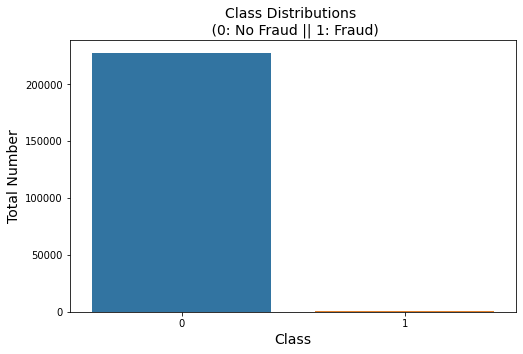

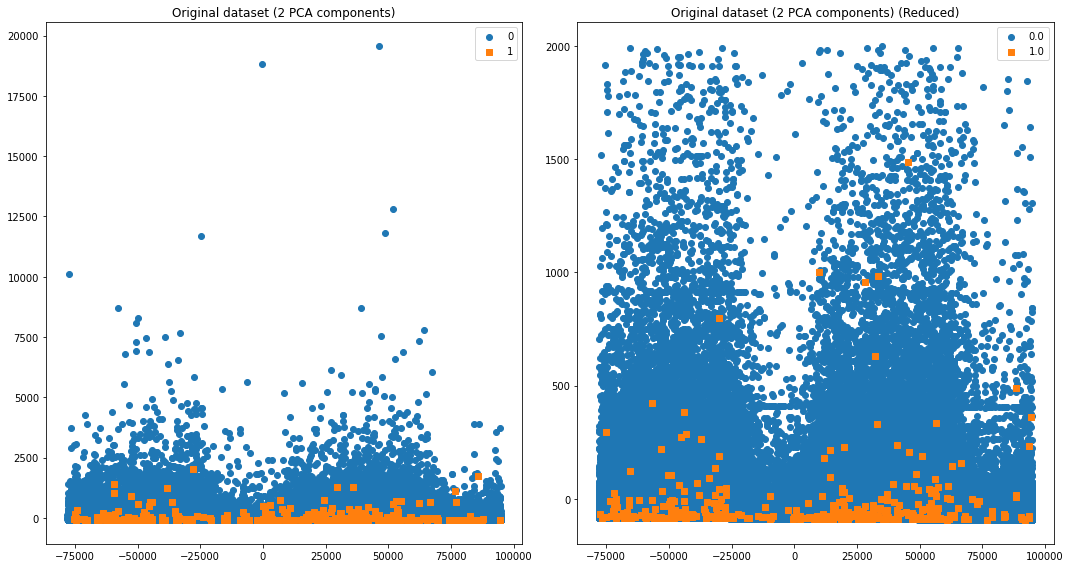


===TEST DATA INFO===
Total samples:  56962


,Class,total
0,0,56861
1,1,101


Negative examples: 99.82 % of the dataset
Positive examples: 0.18 % of the dataset


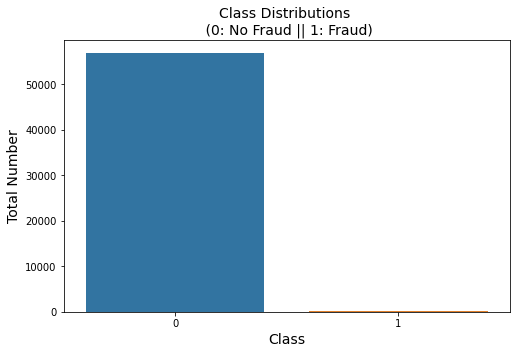

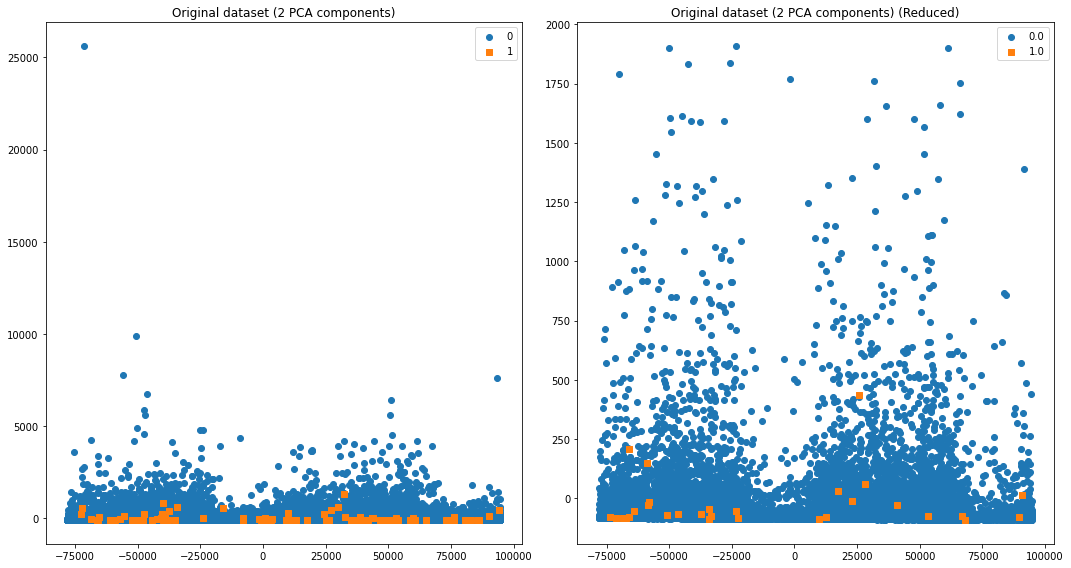

In [8]:
X_data = df.drop('Class', axis=1)
y_data = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

print('===TRAIN DATA INFO===')
check_distribution(y_train)
plot_2d_space(x_data=X_train, y_data=y_train, label='Original dataset (2 PCA components)')

print('\n===TEST DATA INFO===')
check_distribution(y_test)
plot_2d_space(x_data=X_test, y_data=y_test, label='Original dataset (2 PCA components)')

F1: 76.47
Precision: 75.73
Recall: 77.23


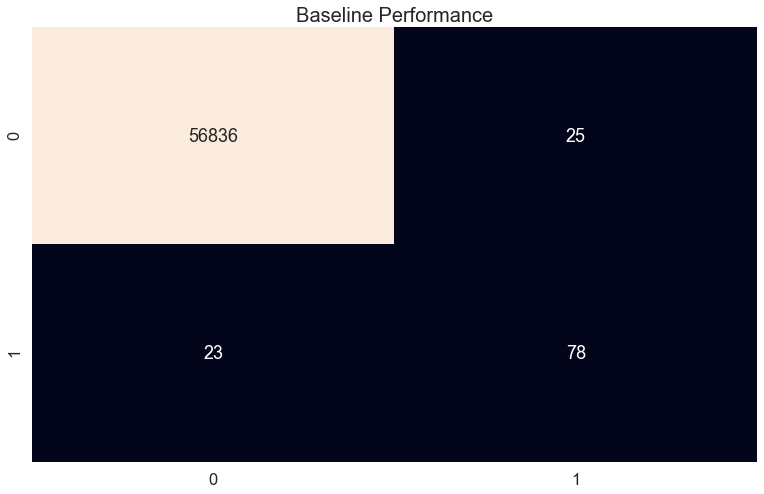

In [9]:
# The evaluation metrics after training a decision tree model with original data will be shown.

base_f1, base_prec, base_recall = train_test_pipeline(x_train=X_train,
                                                      x_test=X_test,
                                                      y_train=y_train, 
                                                      y_test=y_test,
                                                      title='Baseline Performance',
                                                      save=SAVE_RESULT)

if SAVE_RESULT:

    techniques.append('baseline')
    f1s.append(base_f1)
    precs.append(base_prec)
    recalls.append(base_recall)

## 1. Random oversampling and undersampling

1.1. Random oversampling <br>
1.2. Random undersampling <br>

### 1.1. Random oversampling

Increased 227063 examples from positive class.
Total samples:  454908


,Class,total
0,0,227454
1,1,227454


Negative examples: 50.0 % of the dataset
Positive examples: 50.0 % of the dataset


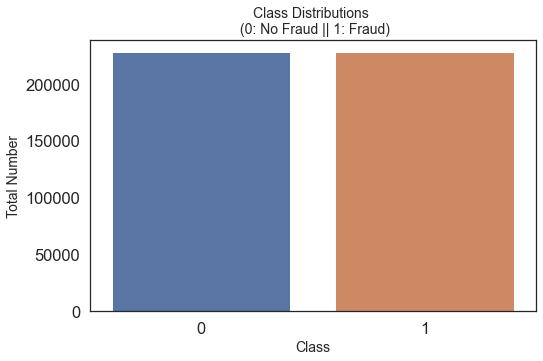

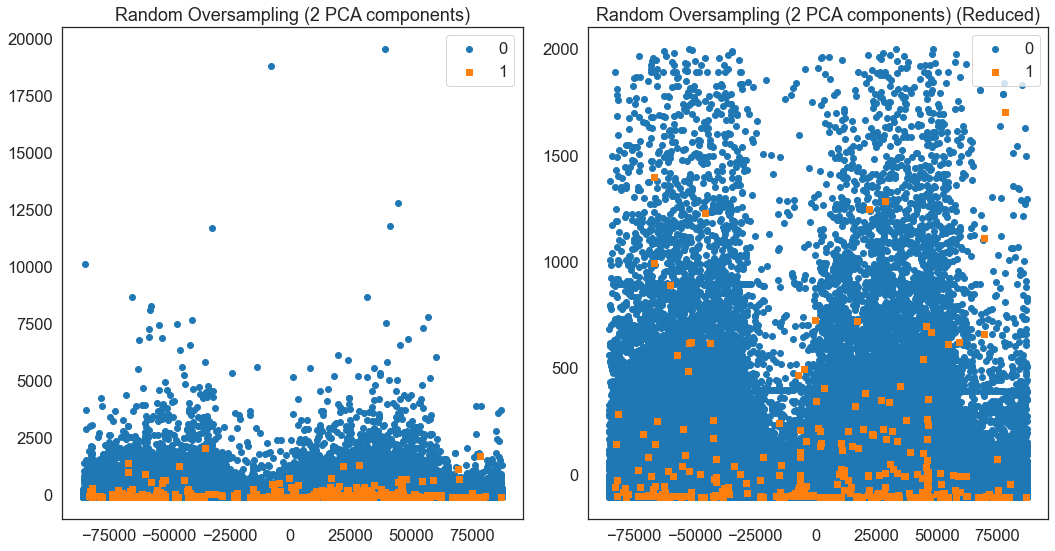

F1: 73.47
Precision: 75.79
Recall: 71.29


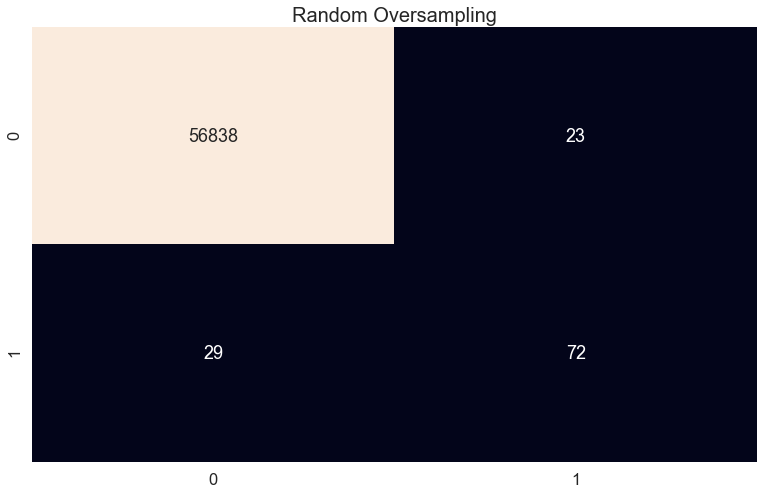

In [10]:
# step 1: Perform random oversampling on train data.

X_train_ros, y_train_ros = RandomOverSampler(random_state=RANDOM_STATE).fit_resample(X_train, y_train)

num_samples = len(X_train)-len(X_train_ros)

if num_samples>0:
    print(f'Reduced {abs(num_samples)} examples from negative class.')
    
else:
    print(f'Increased {abs(num_samples)} examples from positive class.')
    
X_train_ros = pd.DataFrame(X_train_ros)
y_train_ros = pd.DataFrame(y_train_ros, columns=['Class'])
    
# step 2: Check the distribution of resampled data.

check_distribution(y_train_ros)
plot_2d_space(x_data=X_train_ros, y_data=y_train_ros, label='Random Oversampling (2 PCA components)')

# step 3: The evaluation metrics after training a decision tree model with resampled data will be shown.

ros_f1, ros_prec, ros_recall = train_test_pipeline(x_train=X_train_ros,
                                                   x_test=X_test,
                                                   y_train=y_train_ros,
                                                   y_test=y_test,
                                                   title='Random Oversampling',
                                                   save=SAVE_RESULT)

if SAVE_RESULT:

    techniques.append('random_oversampling')
    f1s.append(ros_f1)
    precs.append(ros_prec)
    recalls.append(ros_recall)

### 1.2. Random undersampling

Reduced 227063 examples from negative class.
Total samples:  782


,Class,total
0,0,391
1,1,391


Negative examples: 50.0 % of the dataset
Positive examples: 50.0 % of the dataset


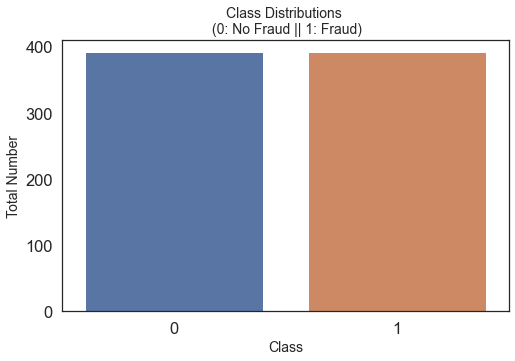

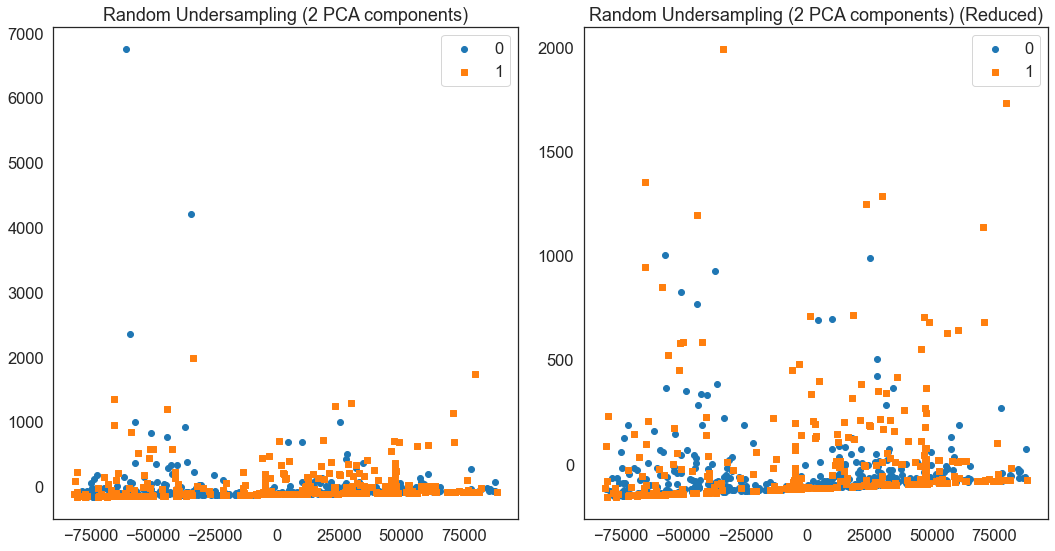

F1: 2.99
Precision: 1.52
Recall: 93.07


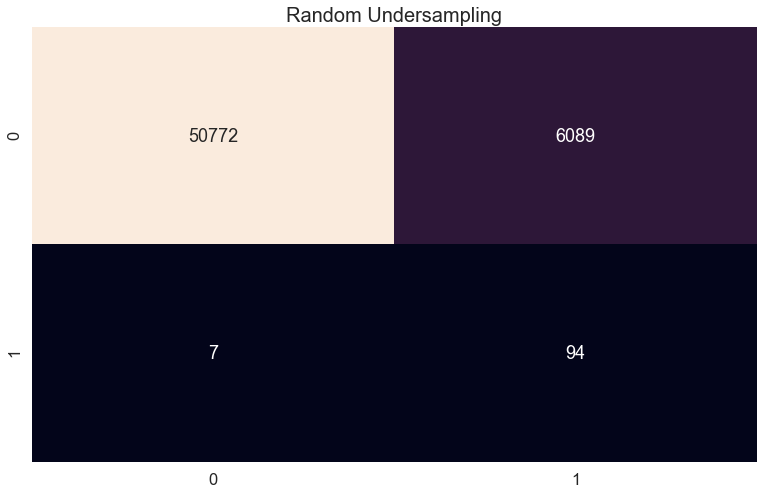

In [11]:
# step 1: Perform random undersampling on train data.

X_train_rus, y_train_rus = RandomUnderSampler(random_state=RANDOM_STATE).fit_resample(X_train, y_train)

num_samples = len(X_train)-len(X_train_rus)

if num_samples>0:
    print(f'Reduced {abs(num_samples)} examples from negative class.')
    
else:
    print(f'Increased {abs(num_samples)} examples from positive class.')
    
X_train_rus = pd.DataFrame(X_train_rus)
y_train_rus = pd.DataFrame(y_train_rus, columns=['Class'])
    
# step 2: Check the distribution of resampled data.

check_distribution(y_train_rus)
plot_2d_space(x_data=X_train_rus, y_data=y_train_rus, label='Random Undersampling (2 PCA components)')

# step 3: The evaluation metrics after training a decision tree model with resampled data will be shown.

rus_f1, rus_prec, rus_recall = train_test_pipeline(x_train=X_train_rus,
                                                   x_test=X_test,
                                                   y_train=y_train_rus,
                                                   y_test=y_test,
                                                   title='Random Undersampling',
                                                   save=SAVE_RESULT)

if SAVE_RESULT:

    techniques.append('random_undersampling')
    f1s.append(rus_f1)
    precs.append(rus_prec)
    recalls.append(rus_recall)

## 2. Informed undersampling

Objective: To overcome the deficiency of information loss introduced in the traditional random undersampling method.

Types of informed undersampling:

2.1. EasyEnsemble <br>
2.2. KNN based <br>
&nbsp;&nbsp;2.2.1. NearMiss-1 <br>
&nbsp;&nbsp;2.2.2. NearMiss-2 <br>
&nbsp;&nbsp;2.2.3. NearMiss-3 <br>

### 2.1. EasyEnsemble

Train size:  227845
Test size:  56962


Negative examples in test data: 56861
Positive examples in test data: 101




/Users/khor.eanyee/miniconda3/envs/imbalance/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


  F1: 9.55
  Precision: 5.03
  Recall: 93.07


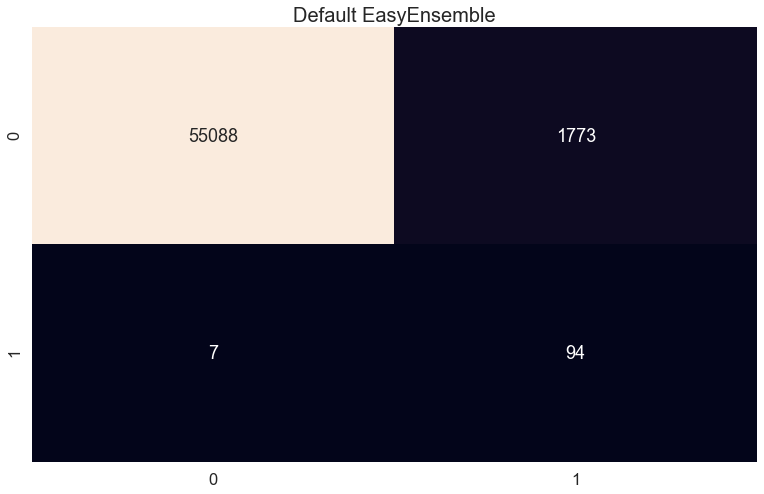

In [12]:
print('Train size: ', len(X_train))
print('Test size: ', len(X_test))
print('\n')

X_train_arr = np.array(X_train)
X_test_arr = np.array(X_test)
y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)

print('Negative examples in test data:', round(np.count_nonzero(y_test_arr==0),2))
print('Positive examples in test data:', round(np.count_nonzero(y_test_arr),2))

print('\n')


eec = EasyEnsembleClassifier(base_estimator=AdaBoostClassifier(n_estimators=50),
                             n_estimators=10,
                             random_state=RANDOM_STATE).fit(X_train_arr, y_train_arr)

y_pred = eec.predict(X_test_arr)

eec_f1 = round(f1_score(y_test, y_pred)*100, 2)
eec_prec = round(precision_score(y_test, y_pred)*100, 2)
eec_recall = round(recall_score(y_test, y_pred)*100, 2)

print('  F1:', eec_f1)
print('  Precision:', eec_prec)
print('  Recall:', eec_recall)

sns.set(font_scale = 1.5)
sns.set_style('white')

plt.figure(figsize=(13,8))

cm2 = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm2, annot=True, fmt='.0f', cbar=False)

plt.title(f'Default EasyEnsemble',fontsize=20)

if SAVE_RESULT:
    
    os.makedirs('output', exist_ok=True)
        
    plt.savefig(f'output/Default EasyEnsemble.png')
    
plt.show()

if SAVE_RESULT:

    techniques.append('easy_ensemble')
    f1s.append(eec_f1)
    precs.append(eec_prec)
    recalls.append(eec_recall)

### 2.2. KNN based

In [13]:
def nearmiss(X_train, y_train, version=1, save=True):
    
    # step 1: Perform undersampling with NearMiss variant on train data.

    X_train_nm, y_train_nm = NearMiss(version=version).fit_resample(X_train, y_train)

    num_samples = len(X_train)-len(X_train_nm)

    if num_samples>0:
        print(f'Reduced {abs(num_samples)} examples from negative class.')

    else:
        print(f'Increased {abs(num_samples)} examples from positive class.')

    X_train_nm = pd.DataFrame(X_train_nm)
    y_train_nm = pd.DataFrame(y_train_nm, columns=['Class'])

    # step 2: Check the distribution of resampled data.

    check_distribution(y_train_nm)
    plot_2d_space(x_data=X_train_nm, y_data=y_train_nm, 
                  label=f'Undersampling with NearMiss-{version} (2 PCA components)')

    # step 3: The evaluation metrics after training a decision tree model with resampled data will be shown.

    nm_f1, nm_prec, nm_recall = train_test_pipeline(x_train=X_train_nm,
                                                    x_test=X_test,
                                                    y_train=y_train_nm,
                                                    y_test=y_test,
                                                    title=f'Undersampling with NearMiss-{version}',
                                                    save=save)
    
    return nm_f1, nm_prec, nm_recall

### 2.2.1. NearMiss-1

Reduced 227063 examples from negative class.
Total samples:  782


,Class,total
0,0,391
1,1,391


Negative examples: 50.0 % of the dataset
Positive examples: 50.0 % of the dataset


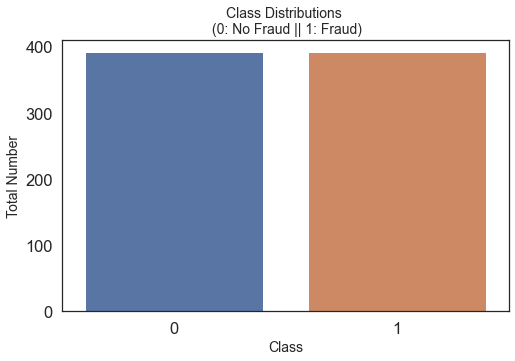

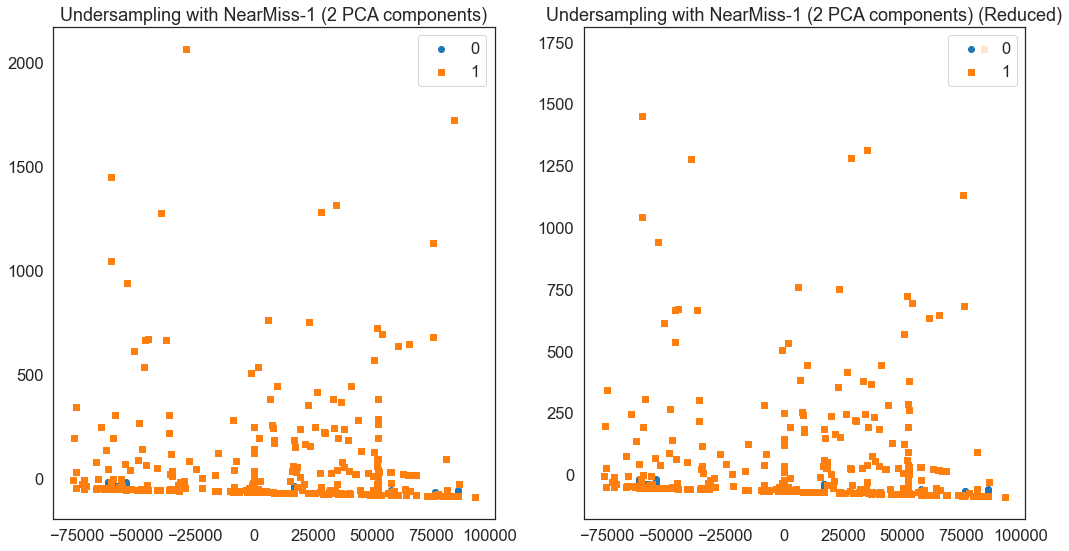

F1: 0.56
Precision: 0.28
Recall: 99.01


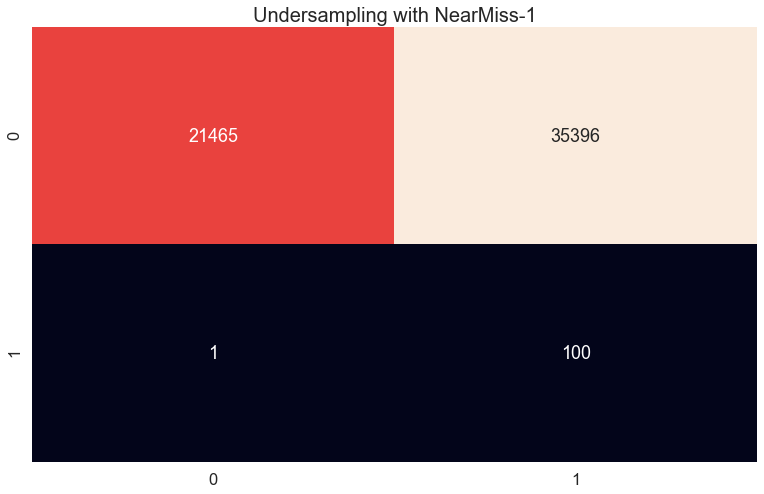

In [14]:
nm1_f1, nm1_prec, nm1_recall, = nearmiss(X_train=X_train, y_train=y_train, version=1, save=SAVE_RESULT)

if SAVE_RESULT:

    techniques.append('near_miss_1')
    f1s.append(nm1_f1)
    precs.append(nm1_prec)
    recalls.append(nm1_recall)

### 2.2.2. NearMiss-2

Reduced 227063 examples from negative class.
Total samples:  782


,Class,total
0,0,391
1,1,391


Negative examples: 50.0 % of the dataset
Positive examples: 50.0 % of the dataset


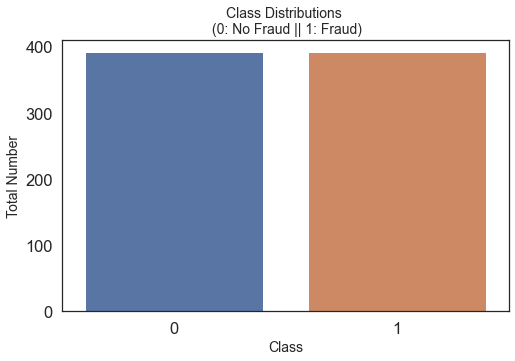

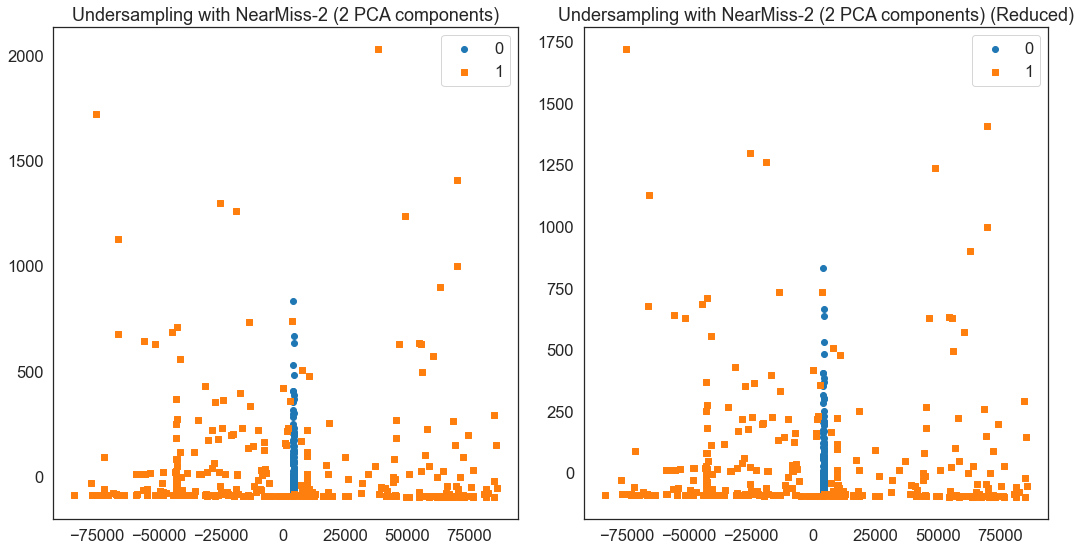

F1: 0.36
Precision: 0.18
Recall: 100.0


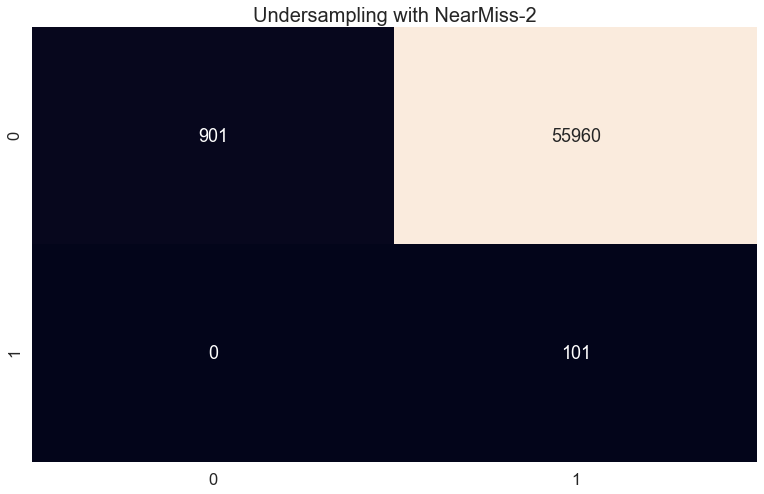

In [15]:
nm2_f1, nm2_prec, nm2_recall, = nearmiss(X_train=X_train, y_train=y_train, version=2, save=SAVE_RESULT)

if SAVE_RESULT:

    techniques.append('near_miss_2')
    f1s.append(nm2_f1)
    precs.append(nm2_prec)
    recalls.append(nm2_recall)

### 2.2.3. NearMiss-3

Reduced 227063 examples from negative class.
Total samples:  782


,Class,total
0,0,391
1,1,391


Negative examples: 50.0 % of the dataset
Positive examples: 50.0 % of the dataset


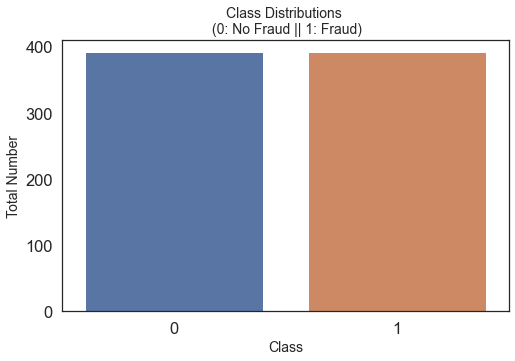

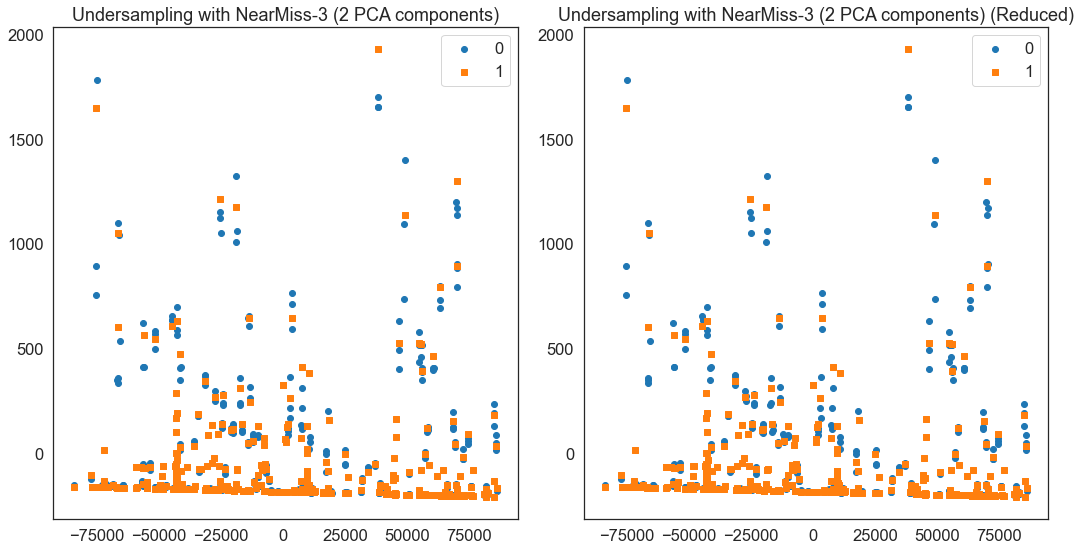

F1: 3.69
Precision: 1.88
Recall: 92.08


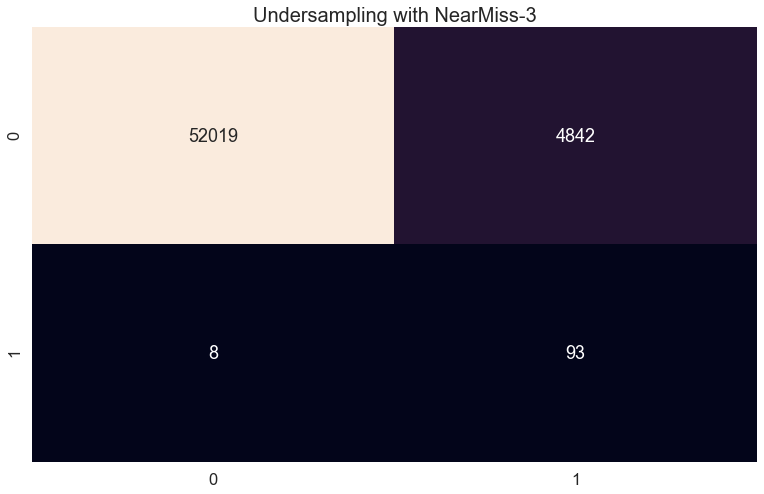

In [16]:
nm3_f1, nm3_prec, nm3_recall, = nearmiss(X_train=X_train, y_train=y_train, version=3, save=SAVE_RESULT)

if SAVE_RESULT:

    techniques.append('near_miss_3')
    f1s.append(nm3_f1)
    precs.append(nm3_prec)
    recalls.append(nm3_recall)

## 3. Synthetic sampling with data generation

<b>Objective: </b> To break the ties introduced by simple oversampling. <br>

<b>Limitation: </b> Over generalization and variance.

3.1. Synthetic minority oversampling technique (SMOTE)


Increased 227063 examples from positive class.
Total samples:  454908


,Class,total
0,0,227454
1,1,227454


Negative examples: 50.0 % of the dataset
Positive examples: 50.0 % of the dataset


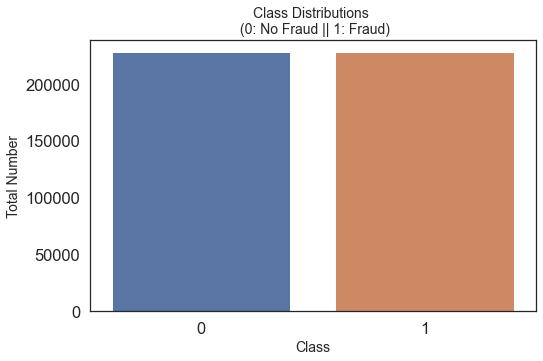

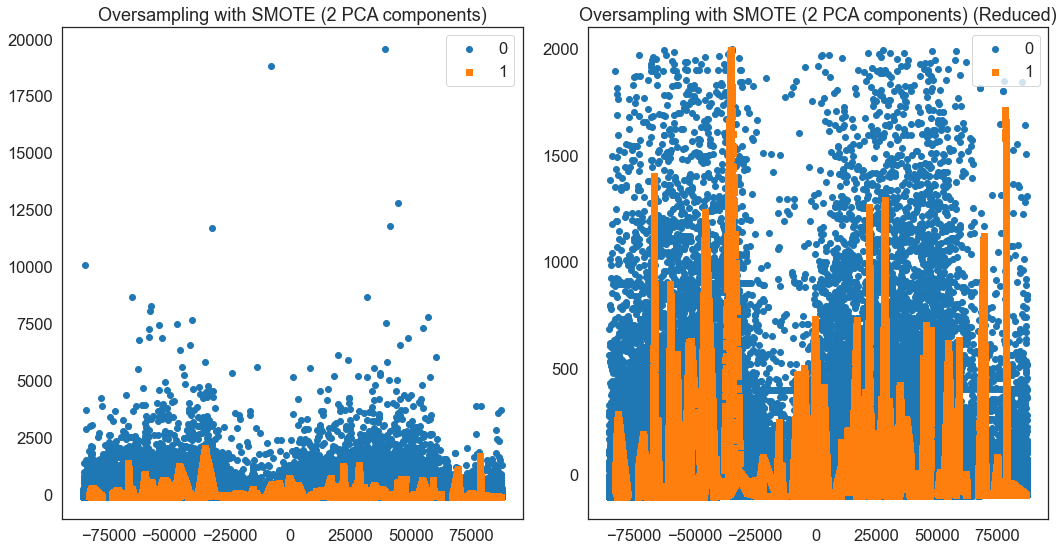

F1: 60.07
Precision: 47.67
Recall: 81.19


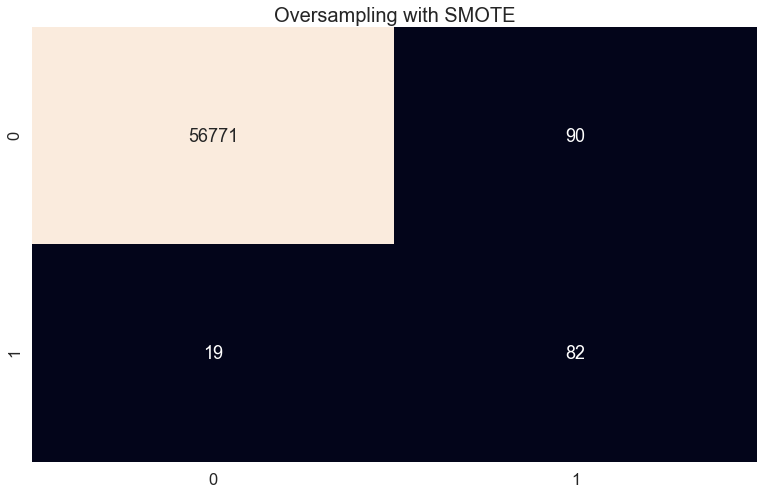

In [17]:
# step 1: Perform oversampling with SMOTE on train data.

X_train_smote, y_train_smote = SMOTE(random_state=RANDOM_STATE).fit_resample(X_train, y_train)

num_samples = len(X_train)-len(X_train_smote)

if num_samples>0:
    print(f'Reduced {abs(num_samples)} examples from negative class.')
    
else:
    print(f'Increased {abs(num_samples)} examples from positive class.')
    
X_train_smote = pd.DataFrame(X_train_smote)
y_train_smote = pd.DataFrame(y_train_smote, columns=['Class'])
    
# step 2: Check the distribution of resampled data.

check_distribution(y_train_smote)
plot_2d_space(x_data=X_train_smote, y_data=y_train_smote, label='Oversampling with SMOTE (2 PCA components)')

# step 3: The evaluation metrics after training a decision tree model with resampled data will be shown.

smote_f1, smote_prec, smote_recall = train_test_pipeline(x_train=X_train_smote,
                                                         x_test=X_test,
                                                         y_train=y_train_smote,
                                                         y_test=y_test,
                                                         title='Oversampling with SMOTE',
                                                         save=SAVE_RESULT)

if SAVE_RESULT:

    techniques.append('smote')
    f1s.append(smote_f1)
    precs.append(smote_prec)
    recalls.append(smote_recall)

## 4. Adaptive synthetic sampling

<b>Objective:</b> To overcome limitation of SMOTE.

4.1. Borderline-SMOTE <br>
&nbsp;&nbsp;4.1.1. Borderline-SMOTE version-1 <br>
&nbsp;&nbsp;4.1.2. Borderline-SMOTE version-2 <br>
4.2. Adaptive synthetic sampling (ADA-SYN)

In [18]:
def bSMOTE(X_train, y_train, kind='borderline-1', save=True):
    
    # step 1: Perform oversampling with borderline SMOTE variant on train data.

    X_train_bsmote, y_train_bsmote = BorderlineSMOTE(random_state=RANDOM_STATE, kind=kind).fit_resample(X_train, y_train)

    num_samples = len(X_train)-len(X_train_bsmote)

    if num_samples>0:
        print(f'Reduced {abs(num_samples)} examples from negative class.')

    else:
        print(f'Increased {abs(num_samples)} examples from positive class.')

    X_train_bsmote = pd.DataFrame(X_train_bsmote)
    y_train_bsmote = pd.DataFrame(y_train_bsmote, columns=['Class'])

    # step 2: Check the distribution of resampled data.

    check_distribution(y_train_bsmote)
    plot_2d_space(x_data=X_train_bsmote, y_data=y_train_bsmote, 
                  label=f'Oversampling with {kind} (2 PCA components)')

    # step 3: The evaluation metrics after training a decision tree model with resampled data will be shown.

    bsm_f1, bsm_prec, bsm_recall = train_test_pipeline(x_train=X_train_bsmote,
                                                       x_test=X_test,
                                                       y_train=y_train_bsmote,
                                                       y_test=y_test,
                                                       title=f'Oversampling with {kind}',
                                                       save=save)
    
    return bsm_f1, bsm_prec, bsm_recall

### 4.1. Borderline-SMOTE

#### 4.1.1. Borderline-SMOTE version 1

Increased 227063 examples from positive class.
Total samples:  454908


,Class,total
0,0,227454
1,1,227454


Negative examples: 50.0 % of the dataset
Positive examples: 50.0 % of the dataset


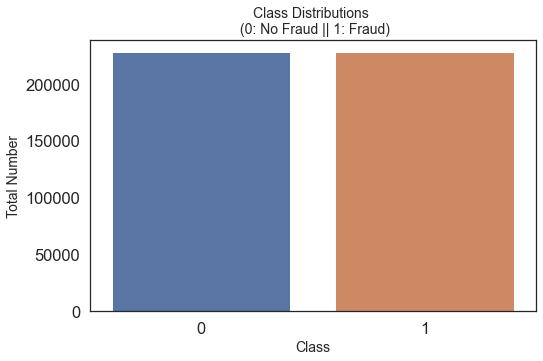

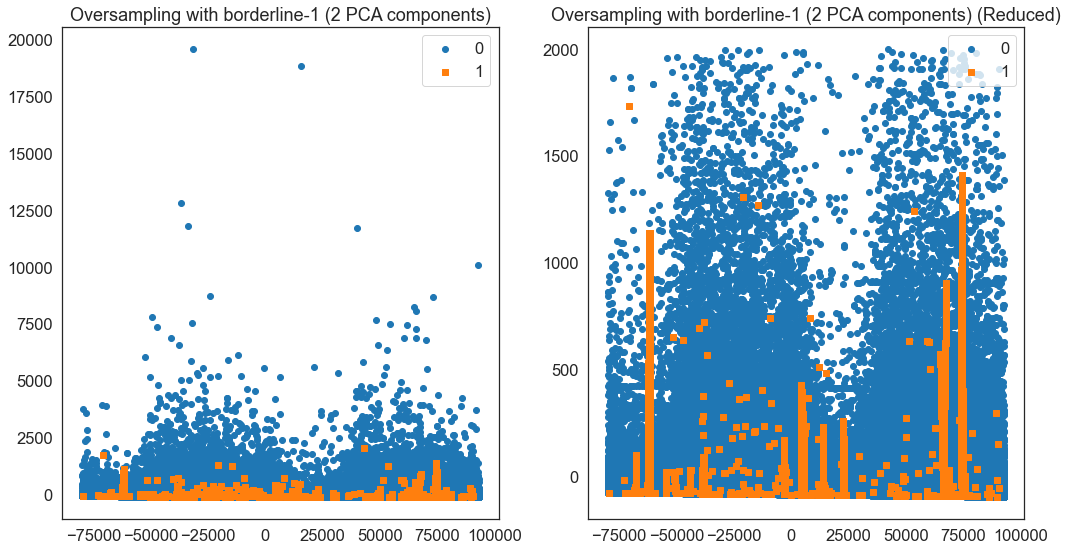

F1: 70.27
Precision: 64.46
Recall: 77.23


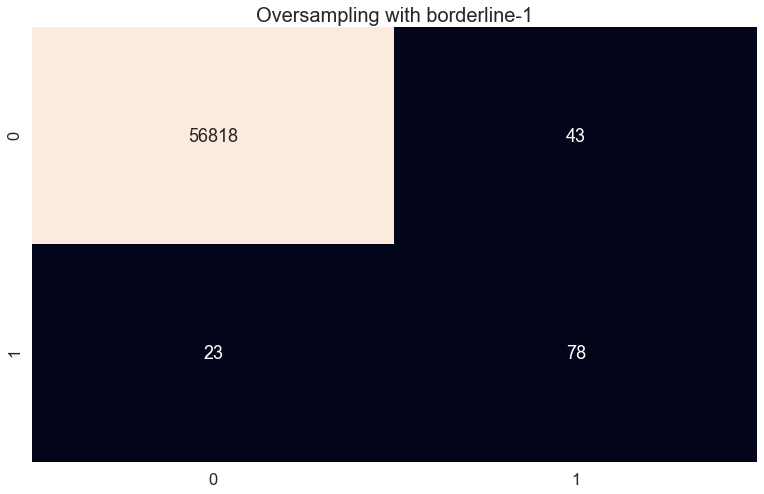

In [19]:
bsm1_f1, bsm1_prec, bsm1_recall = bSMOTE(X_train, y_train, kind='borderline-1', save=SAVE_RESULT)

if SAVE_RESULT:

    techniques.append('borderline_smote_1')
    f1s.append(bsm1_f1)
    precs.append(bsm1_prec)
    recalls.append(bsm1_recall)

#### 4.1.2. Borderline-SMOTE version 2

Increased 227063 examples from positive class.
Total samples:  454908


,Class,total
0,0,227454
1,1,227454


Negative examples: 50.0 % of the dataset
Positive examples: 50.0 % of the dataset


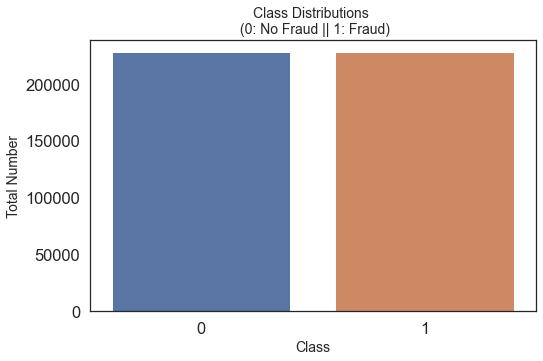

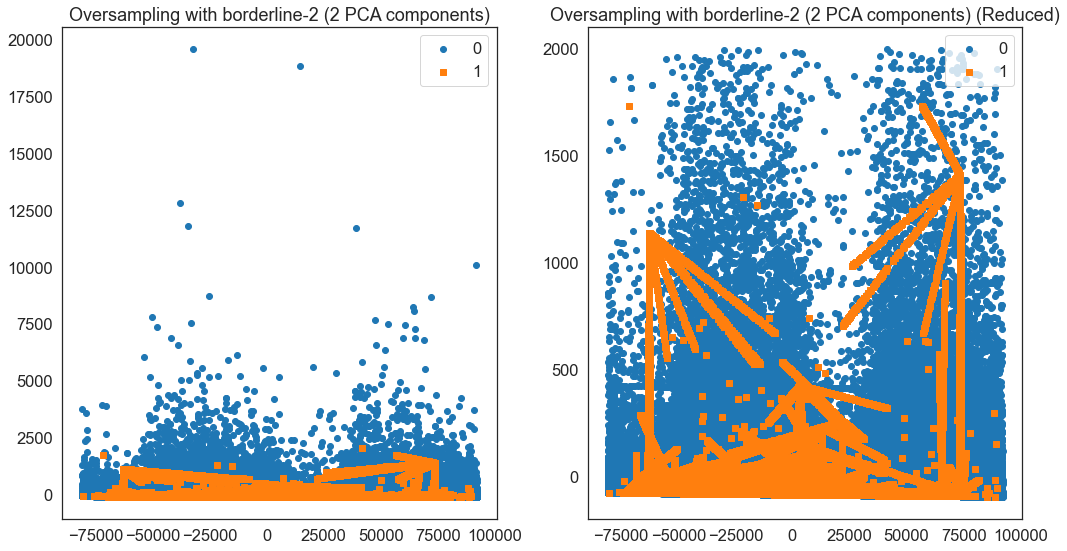

F1: 68.88
Precision: 59.29
Recall: 82.18


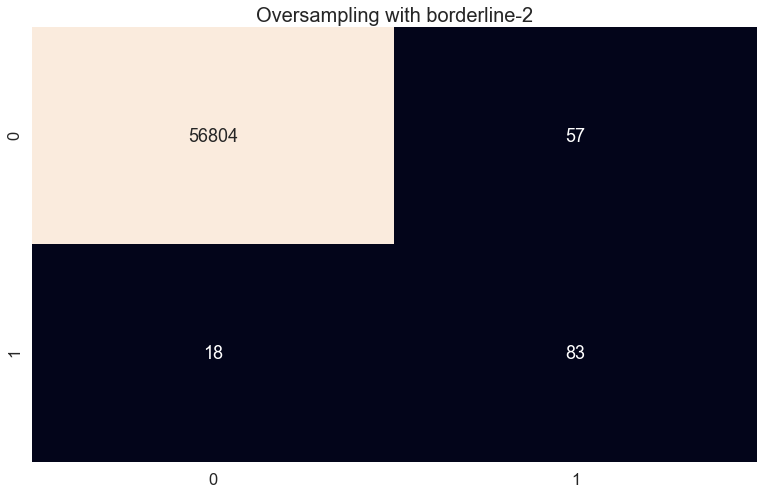

In [20]:
bsm2_f1, bsm2_prec, bsm2_recall = bSMOTE(X_train, y_train, kind='borderline-2', save=SAVE_RESULT)

if SAVE_RESULT:

    techniques.append('borderline_smote_2')
    f1s.append(bsm2_f1)
    precs.append(bsm2_prec)
    recalls.append(bsm2_recall)

### 4.2. Adaptive synthetic sampling (ADA-SYN)

Increased 227169 examples from positive class.
Total samples:  455014


,Class,total
0,0,227454
1,1,227560


Negative examples: 49.99 % of the dataset
Positive examples: 50.01 % of the dataset


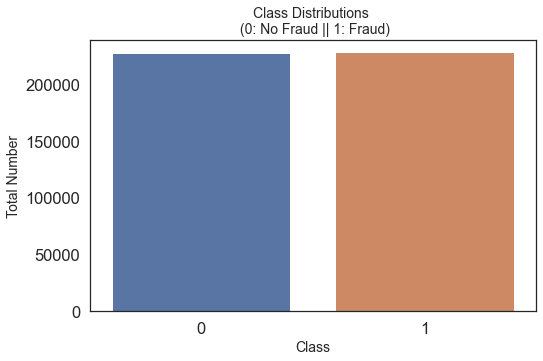

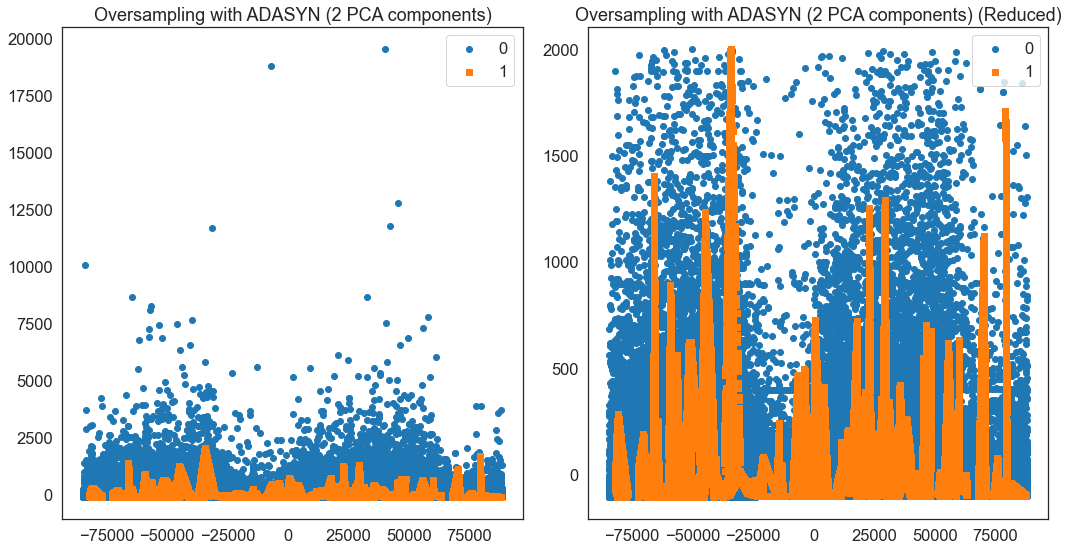

F1: 52.88
Precision: 40.21
Recall: 77.23


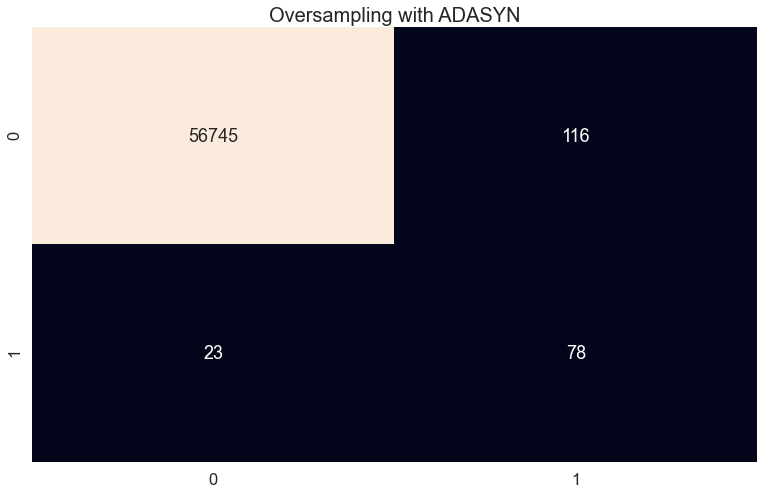

In [21]:
# step 1: Perform oversampling with ADASYN on train data.

X_train_ada, y_train_ada = ADASYN(random_state=RANDOM_STATE).fit_resample(X_train, y_train)

num_samples = len(X_train)-len(X_train_ada)

if num_samples>0:
    print(f'Reduced {abs(num_samples)} examples from negative class.')

else:
    print(f'Increased {abs(num_samples)} examples from positive class.')

X_train_ada = pd.DataFrame(X_train_ada)
y_train_ada = pd.DataFrame(y_train_ada, columns=['Class'])

# step 2: Check the distribution of resampled data.

check_distribution(y_train_ada)
plot_2d_space(x_data=X_train_ada, y_data=y_train_ada, 
              label=f'Oversampling with ADASYN (2 PCA components)')

# step 3: The evaluation metrics after training a decision tree model with resampled data will be shown.

ada_f1, ada_prec, ada_recall = train_test_pipeline(x_train=X_train_ada,
                                                   x_test=X_test,
                                                   y_train=y_train_ada,
                                                   y_test=y_test,
                                                   title=f'Oversampling with ADASYN',
                                                   save=SAVE_RESULT)

if SAVE_RESULT:

    techniques.append('adasyn')
    f1s.append(ada_f1)
    precs.append(ada_prec)
    recalls.append(ada_recall)

## 5. Sampling with data cleaning techniques

5.1. SMOTE+ENN <br>
5.2. SMOTE+Tomek Links <br>

### 5.1. SMOTE+ENN

Increased 197649 examples from positive class.
Total samples:  425494


,Class,total
0,0,207922
1,1,217572


Negative examples: 48.87 % of the dataset
Positive examples: 51.13 % of the dataset


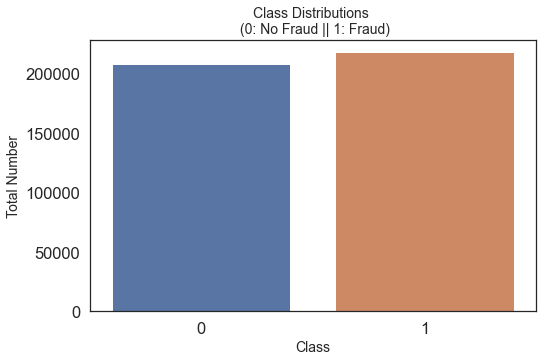

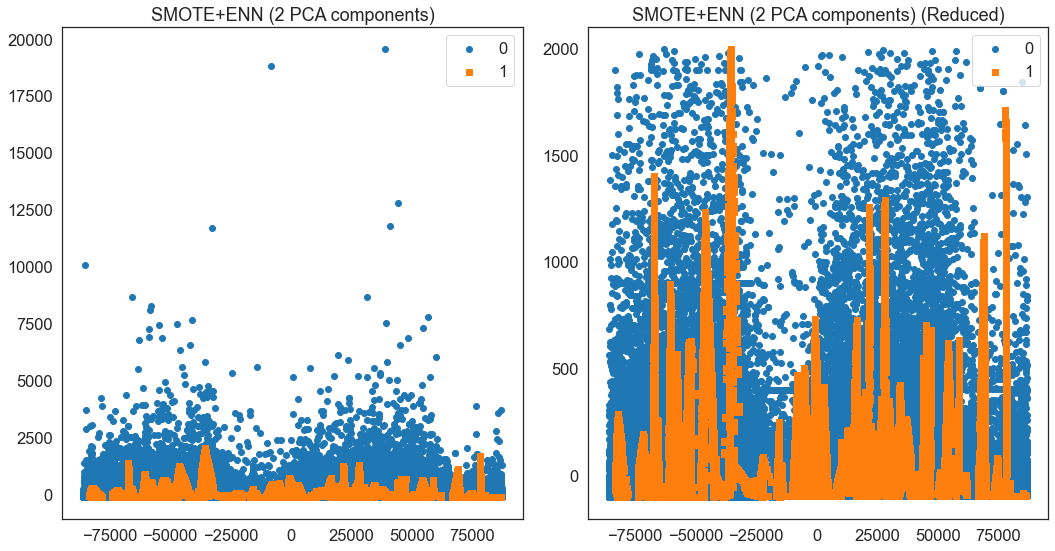

F1: 55.52
Precision: 41.92
Recall: 82.18


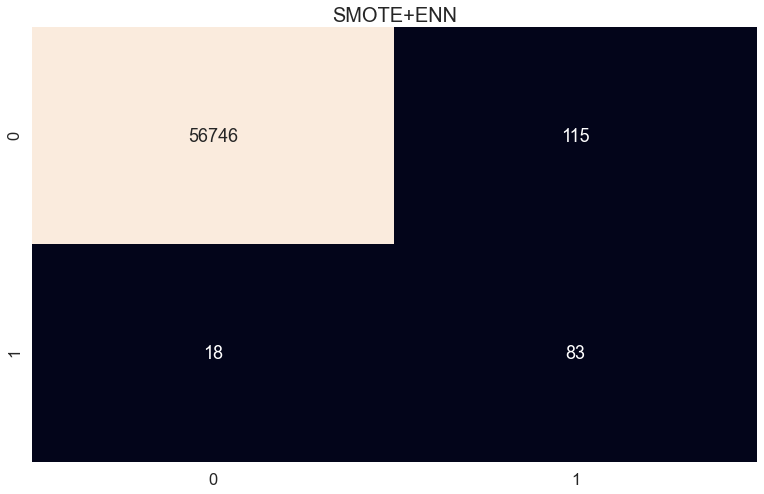

In [22]:
# step 1: Perform oversampling with SMOTE and undersampling with ENN on train data.

X_train_sme, y_train_sme = SMOTEENN(random_state=RANDOM_STATE).fit_resample(X_train, y_train)

num_samples = len(X_train)-len(X_train_sme)

if num_samples>0:
    print(f'Reduced {abs(num_samples)} examples from negative class.')

else:
    print(f'Increased {abs(num_samples)} examples from positive class.')

X_train_sme = pd.DataFrame(X_train_sme)
y_train_sme = pd.DataFrame(y_train_sme, columns=['Class'])

# step 2: Check the distribution of resampled data.

check_distribution(y_train_sme)
plot_2d_space(x_data=X_train_sme, y_data=y_train_sme, 
              label=f'SMOTE+ENN (2 PCA components)')

# step 3: The evaluation metrics after training a decision tree model with resampled data will be shown.

sme_f1, sme_prec, sme_recall = train_test_pipeline(x_train=X_train_sme,
                                                   x_test=X_test,
                                                   y_train=y_train_sme,
                                                   y_test=y_test,
                                                   title=f'SMOTE+ENN',
                                                   save=SAVE_RESULT)

if SAVE_RESULT:

    techniques.append('smote_enn')
    f1s.append(sme_f1)
    precs.append(sme_prec)
    recalls.append(sme_recall)

### 5.2. SMOTE+Tomek Links

Increased 225543 examples from positive class.
Total samples:  453388


,Class,total
0,0,226694
1,1,226694


Negative examples: 50.0 % of the dataset
Positive examples: 50.0 % of the dataset


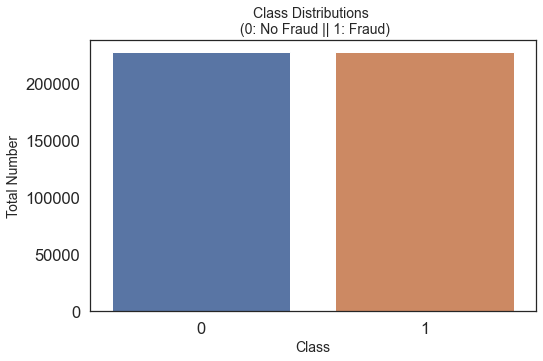

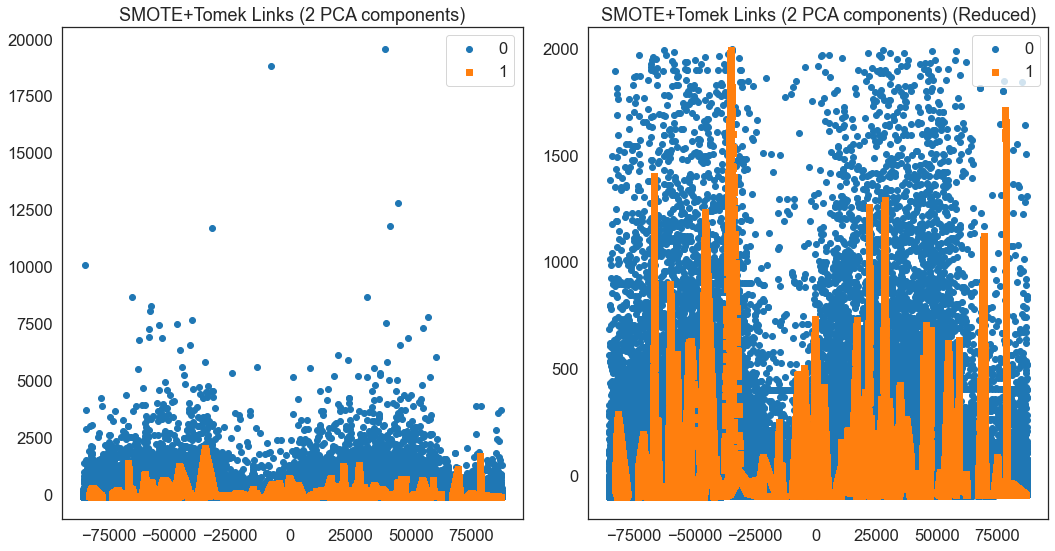

F1: 58.52
Precision: 46.75
Recall: 78.22


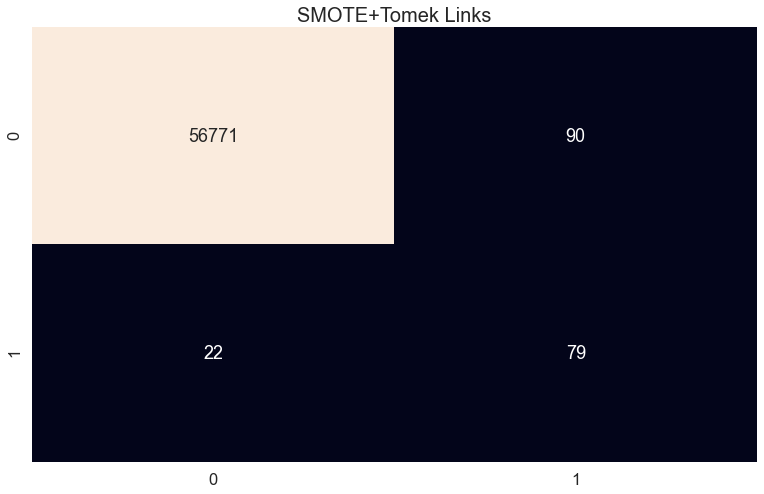

In [23]:
# step 1: Perform oversampling with SMOTE and undersampling with Tomek Links on train data.

X_train_smt, y_train_smt = SMOTETomek(random_state=RANDOM_STATE).fit_resample(X_train, y_train)

num_samples = len(X_train)-len(X_train_smt)

if num_samples>0:
    print(f'Reduced {abs(num_samples)} examples from negative class.')

else:
    print(f'Increased {abs(num_samples)} examples from positive class.')

X_train_smt = pd.DataFrame(X_train_smt)
y_train_smt = pd.DataFrame(y_train_smt, columns=['Class'])

# step 2: Check the distribution of resampled data.

check_distribution(y_train_smt)
plot_2d_space(x_data=X_train_smt, y_data=y_train_smt, 
              label=f'SMOTE+Tomek Links (2 PCA components)')

# step 3: The evaluation metrics after training a decision tree model with resampled data will be shown.

smt_f1, smt_prec, smt_recall = train_test_pipeline(x_train=X_train_smt,
                                                   x_test=X_test,
                                                   y_train=y_train_smt,
                                                   y_test=y_test,
                                                   title=f'SMOTE+Tomek Links',
                                                   save=SAVE_RESULT)

if SAVE_RESULT:

    techniques.append('smote_tomek')
    f1s.append(smt_f1)
    precs.append(smt_prec)
    recalls.append(smt_recall)

## 6. Extra: Ensemble classifier using samplers internally

Train size:  227845
Test size:  56962


Negative examples in test data: 56861
Positive examples in test data: 101




<ipython-input-24-289c32616f33>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  brf = BalancedRandomForestClassifier(random_state=RANDOM_STATE).fit(X_train_arr, y_train_arr)


  F1: 12.6
  Precision: 6.76
  Recall: 92.08


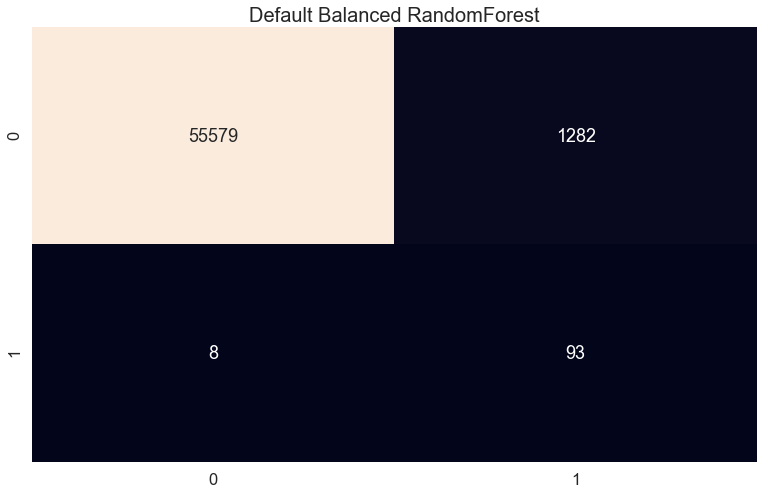

In [24]:
print('Train size: ', len(X_train))
print('Test size: ', len(X_test))
print('\n')

X_train_arr = np.array(X_train)
X_test_arr = np.array(X_test)
y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)

print('Negative examples in test data:', round(np.count_nonzero(y_test_arr==0),2))
print('Positive examples in test data:', round(np.count_nonzero(y_test_arr),2))

print('\n')


brf = BalancedRandomForestClassifier(random_state=RANDOM_STATE).fit(X_train_arr, y_train_arr)

y_pred = brf.predict(X_test_arr)

brf_f1 = round(f1_score(y_test, y_pred)*100, 2)
brf_prec = round(precision_score(y_test, y_pred)*100, 2)
brf_recall = round(recall_score(y_test, y_pred)*100, 2)

print('  F1:', brf_f1)
print('  Precision:', brf_prec)
print('  Recall:', brf_recall)

sns.set(font_scale = 1.5)
sns.set_style('white')

plt.figure(figsize=(13,8))

cm2 = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm2, annot=True, fmt='.0f', cbar=False)

plt.title(f'Default Balanced RandomForest',fontsize=20)

if SAVE_RESULT:
    
    os.makedirs('output', exist_ok=True)
        
    plt.savefig(f'output/Default Balanced RandomForest.png')
    
plt.show()

if SAVE_RESULT:

    techniques.append('balanced_randomforest')
    f1s.append(brf_f1)
    precs.append(brf_prec)
    recalls.append(brf_recall)

### Convert results into dataframe and save

In [25]:
df_result = pd.DataFrame(list(zip(techniques, f1s, precs, recalls)), 
                  columns =['technique', 'f1', 'precision', 'recall']) 

df_result.to_csv('output/df_result.csv', index=False)

### Read results

In [26]:
df_result = pd.read_csv('output/df_result.csv')

In [27]:
df_result

,technique,f1,precision,recall
0,baseline,76.47,75.73,77.23
1,random_oversampling,73.47,75.79,71.29
2,random_undersampling,2.99,1.52,93.07
3,easy_ensemble,9.55,5.03,93.07
4,near_miss_1,0.56,0.28,99.01
5,near_miss_2,0.36,0.18,100.00
6,near_miss_3,3.69,1.88,92.08
7,smote,60.07,47.67,81.19
8,borderline_smote_1,70.27,64.46,77.23
9,borderline_smote_2,68.88,59.29,82.18


In [28]:
def plot_results(data):
    
    sns.set(font_scale = 1.5)
    sns.set_style('white')

    plt.figure(figsize=(13,8))
    
    sns.lineplot(x='technique', y='f1', data=data, linewidth = 3, label='f1', sort=False, color='black')
    sns.lineplot(x='technique', y='precision', data=data, linewidth = 3, label='precision', sort=False, color='lightcoral')
    sns.lineplot(x='technique', y='recall', data=data, linewidth = 3, label='recall', sort=False, color='steelblue')
        
    for i, v in enumerate(data['f1']):
        plt.text(i-0.2, v+2.5, str(v), color='black', fontsize=14)
            
    ax1_max = data[['f1','precision','recall']].max().max()
    
    plt.ylim(bottom=0-5, top=ax1_max+10)
    
    plt.xlabel('Techniques', fontsize=18)
    plt.ylabel(f'Scores', fontsize=18)
    plt.title(f'Scores', fontsize=21)
    
    locs, _ = plt.xticks()
    plt.xticks(locs, data['technique'], rotation=45)
    
    plt.legend(loc = 'lower left')
    
    plt.show()

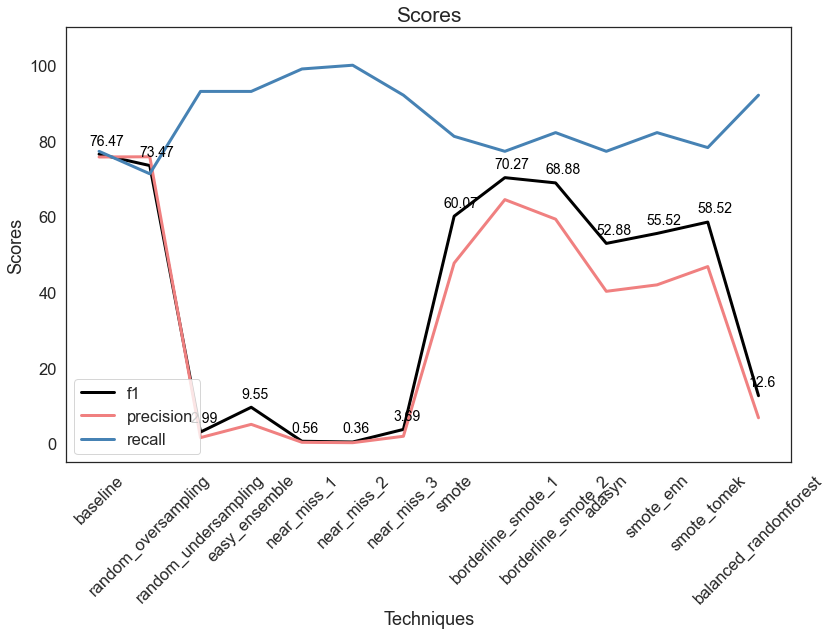

In [29]:
plot_results(df_result)

### Conclusion

<span style="color:blue"><b>Disclaimer: The conclusion is solely based on this dataset and the techniques above. It might be vary for different dataset and different techniques that handling imbalance issue. </b></span>

1. Suprisingly, none of the F1 score from sampling techniques can beat the baseline performance. From this perspective, none of the sampling techniques above should be applied.

2. However, for credit card fraud, maybe it is good if the model can increase the prediction of positive class with slightly more false positive. The error can then be reduced if we have human inspections as the final decision line. From this perspective, the Balanced Random Forest can be considered.

3. Imblearn is an easy-to-use library that can be used as the first attempt to handle imbalance issue.

---

## Reference

1. https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#t7
2. https://pypi.org/project/imbalanced-learn/#id26

## Recommended Reading

Tuning in EasyEnsemble: https://www.kaggle.com/pratikchoudhari/guide-to-imbalanced-classification-easy-ensemble